In [ ]:
%tensorflow_version 2.x

import tensorflow as tf
import tensorflow_hub as hub
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# grab the model from Tensorflow hub and append a softmax activation
model = tf.keras.Sequential([
    hub.KerasLayer('https://tfhub.dev/google/tf2-preview/inception_v3/classification/4'),
    tf.keras.layers.Activation('softmax')
])

# build the model based on a specified batch input shape
model.build([None, 300, 300, 3])

In [ ]:
!wget -O image.jpg https://cdn.pixabay.com/photo/2018/02/27/14/11/the-pacific-ocean-3185553_960_720.jpg

# If you want to try the cat, uncomment this line
# !wget -O image.jpg https://cdn.pixabay.com/photo/2018/02/27/14/11/the-pacific-ocean-3185553_960_720.jpg

--2021-04-10 23:25:21--  https://cdn.pixabay.com/photo/2018/02/27/14/11/the-pacific-ocean-3185553_960_720.jpg
Resolving cdn.pixabay.com (cdn.pixabay.com)... 104.18.21.183, 104.18.20.183, 2606:4700::6812:14b7, ...
Connecting to cdn.pixabay.com (cdn.pixabay.com)|104.18.21.183|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 165993 (162K) [image/jpeg]
Saving to: ‘image.jpg’

image.jpg           100%[===================>] 162.10K  --.-KB/s    in 0.03s   

2021-04-10 23:25:22 (5.34 MB/s) - ‘image.jpg’ saved [165993/165993]



In [ ]:
# read the image
img = cv2.imread('image.jpg')

# format it to be in the RGB colorspace
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 

# resize to 300x300 and normalize pixel values to be in the range [0, 1]
img = cv2.resize(img, (300, 300)) / 255.0

# add a batch dimension in front
image = np.expand_dims(img, axis=0)

image.shape

(1, 300, 300, 3)

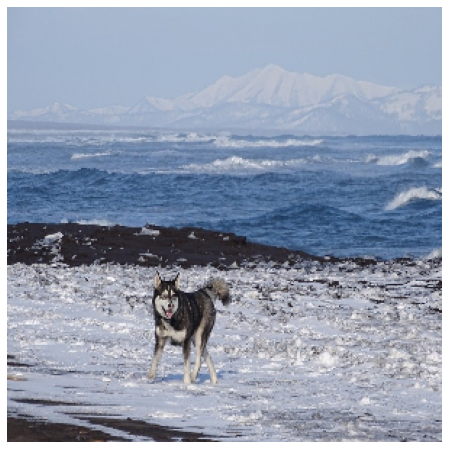

In [ ]:
plt.figure(figsize=(8, 8))
plt.imshow(img)
plt.axis('off')
plt.show()

In [ ]:
#Compute Gradients
#You will now get the gradients of the loss with respect to the input image pixels. This is the key step to generate the map later

In [ ]:
# Siberian Husky's class ID in ImageNet
class_index = 251

In [ ]:
# number of classes in the model's training data
num_classes = 1001

In [ ]:
# convert to one hot representation to match our softmax activation in the model definition
expected_output = tf.one_hot([class_index] * image.shape[0], num_classes)

In [ ]:
print(expected_output)
np.argmax(expected_output.numpy())

tf.Tensor([[0. 0. 0. ... 0. 0. 0.]], shape=(1, 1001), dtype=float32)


251

In [ ]:
with tf.GradientTape() as tape: #Record operations for automatic differentiation.
    # cast image to float
    inputs = tf.cast(image, tf.float32)

    # watch the input pixels
    tape.watch(inputs)

    # generate the predictions
    predictions = model(inputs)

    # get the loss
    loss = tf.keras.losses.categorical_crossentropy(expected_output, predictions)

In [ ]:
# get the gradient with respect to the inputs
gradients = tape.gradient(loss, inputs)

In [ ]:
gradients.shape

TensorShape([1, 300, 300, 3])

In [ ]:
#Visualize the results

In [ ]:
#Now that you have the gradients, you will do some postprocessing to generate the saliency maps and overlay it on the image.

# reduce the RGB image to grayscale
grayscale_tensor = tf.reduce_sum(tf.abs(gradients), axis=-1)

In [ ]:
print(gradients.shape)
print(grayscale_tensor.shape)

(1, 300, 300, 3)
(1, 300, 300)


In [ ]:
##sanity check after converting gradients to grayscale
print(np.argmax(grayscale_tensor.numpy()))
print(tf.reduce_max(grayscale_tensor))
print(np.argmin(grayscale_tensor.numpy()))
print(tf.reduce_min(grayscale_tensor))

65527
tf.Tensor(1.2475202, shape=(), dtype=float32)
299
tf.Tensor(0.0, shape=(), dtype=float32)


In [ ]:
# normalize the pixel values to be in the range [0, 255].
# the max value in the grayscale tensor will be pushed to 255.
# the min value will be pushed to 0.
normalized_tensor = tf.cast(255*(grayscale_tensor-tf.reduce_min(grayscale_tensor))/(tf.reduce_max(grayscale_tensor)-tf.reduce_min(grayscale_tensor)),tf.uint8,)

In [ ]:
##sanity check after Normalizing
print(np.argmax(normalized_tensor.numpy()))
print(tf.reduce_max(normalized_tensor))
print(np.argmin(normalized_tensor.numpy()))
print(tf.reduce_min(normalized_tensor))
normalized_tensor.shape

65527
tf.Tensor(255, shape=(), dtype=uint8)
1
tf.Tensor(0, shape=(), dtype=uint8)


TensorShape([1, 300, 300])

In [ ]:
# remove the channel dimension to make the tensor a 2d tensor
normalized_tensor = tf.squeeze(normalized_tensor)

In [ ]:
#sanity check after squeezing
print(np.argmax(normalized_tensor.numpy()))
print(tf.reduce_max(normalized_tensor))
print(np.argmin(normalized_tensor.numpy()))
print(tf.reduce_min(normalized_tensor))
normalized_tensor.shape #removed dimension1(channel) by squeezing

65527
tf.Tensor(255, shape=(), dtype=uint8)
1
tf.Tensor(0, shape=(), dtype=uint8)


TensorShape([300, 300])

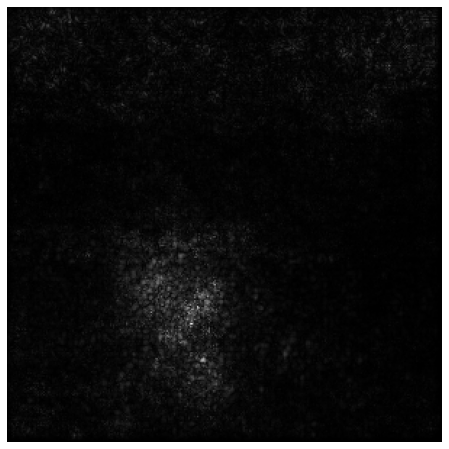

In [ ]:
#Plot normalized tensor
plt.figure(figsize=(8, 8))
plt.axis('off')
plt.imshow(normalized_tensor, cmap='gray')
plt.show()

In [ ]:
#superimpose the normalized tensor to the input image to get more context
gradient_color = cv2.applyColorMap(normalized_tensor.numpy(), cv2.COLORMAP_HOT)
gradient_color = gradient_color / 255.0
super_imposed = cv2.addWeighted(img, 0.5, gradient_color, 0.5, 0.0)

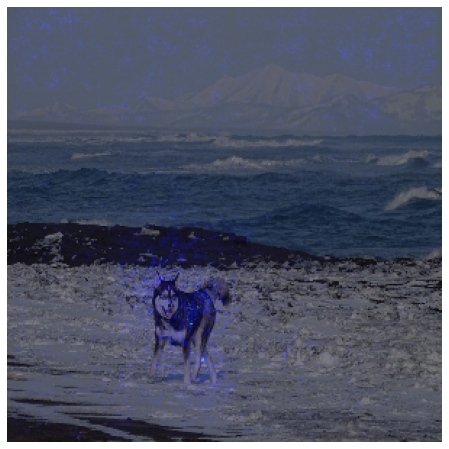

In [ ]:
#plot superimposed image
plt.figure(figsize=(8, 8))
plt.imshow(super_imposed)
plt.axis('off')
plt.show()